In [1]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

sidr_data = genfromtxt('../input/covid-irdp/COVID_US_CDR_timeserise(300Days).csv.csv', delimiter=',') #in the form of [t,S,I,D,R]

torch.manual_seed(1234)

In [2]:
sidr_data = sidr_data[:, :310]

In [3]:
%%time

PATH = 'sidr_norm_simple' 

class DINN(nn.Module):
    def __init__(self, t, S_data, I_data, D_data, R_data): #[t,S,I,D,R]
        super(DINN, self).__init__()
        self.N = 3.3e8 #population size
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 
        self.S = torch.tensor(S_data)
        self.I = torch.tensor(I_data)
        self.D = torch.tensor(D_data)
        self.R = torch.tensor(R_data)

        self.losses = []
        self.errors = []
        self.save = 2 #which file to save to

        self.alpha_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        
        #find values for normalization
        self.S_max = max(self.S)
        self.I_max = max(self.I)
        self.D_max = max(self.D)
        self.R_max = max(self.R)
        self.S_min = min(self.S)
        self.I_min = min(self.I)
        self.D_min = min(self.D)
        self.R_min = min(self.R)

        #normalize
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)

        #matrices (x4 for S,I,D,R) for the gradients
        self.m1 = torch.zeros((len(self.t), 4)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 4)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 4)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 4)); self.m4[:, 3] = 1

        #NN
        self.net_sidr = self.Net_sidr()
        self.params = list(self.net_sidr.parameters())
        self.params.extend(list([self.alpha_tilda, self.beta_tilda, self.gamma_tilda]))

    @property
    def alpha(self):
        return self.alpha_tilda

    @property
    def beta(self):
        return self.beta_tilda

    @property
    def gamma(self):
        return self.gamma_tilda


    #nets
    class Net_sidr(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.Net_sidr, self).__init__()
            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 4) #outputs S, I, D, R

        def forward(self, t_batch):
            sidr=F.relu(self.fc1(t_batch))
            sidr=F.relu(self.fc2(sidr))
            sidr=F.relu(self.fc3(sidr))
            sidr=F.relu(self.fc4(sidr))
            sidr=F.relu(self.fc5(sidr))
            sidr=F.relu(self.fc6(sidr))
            sidr=F.relu(self.fc7(sidr))
            sidr=F.relu(self.fc8(sidr))
            sidr=self.out(sidr)
            return sidr
            
    def net_f(self, t_batch):
        sidr_hat = self.net_sidr(t_batch)

        S_hat, I_hat, D_hat, R_hat = sidr_hat[:,0], sidr_hat[:,1], sidr_hat[:,2], sidr_hat[:,3]

        #S_t
        sidr_hat.backward(self.m1, retain_graph=True)
        S_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_t
        sidr_hat.backward(self.m2, retain_graph=True)
        I_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #D_t
        sidr_hat.backward(self.m3, retain_graph=True)
        D_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #R_t
        sidr_hat.backward(self.m4, retain_graph=True)
        R_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #unnormalize
        S = self.S_min + (self.S_max - self.S_min) * S_hat
        I = self.I_min + (self.I_max - self.I_min) * I_hat
        D = self.D_min + (self.D_max - self.D_min) * D_hat      
        R = self.R_min + (self.R_max - self.R_min) * R_hat

        f1_hat = S_hat_t - (-(self.alpha / self.N) * S * I)  / (self.S_max - self.S_min)
        f2_hat = I_hat_t - ((self.alpha / self.N) * S * I - self.beta * I - self.gamma * I ) / (self.I_max - self.I_min)
        f3_hat = D_hat_t - (self.gamma * I) / (self.D_max - self.D_min)
        f4_hat = R_hat_t - (self.beta * I ) / (self.R_max - self.R_min)

        return f1_hat, f2_hat, f3_hat, f4_hat, S_hat, I_hat, D_hat, R_hat
    
    def load(self):
      # Load checkpoint
      try:
        checkpoint = torch.load(PATH + str(self.save)+'.pt') 
        print('\nloading pre-trained model...')
        self.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        epoch = checkpoint['epoch']
        self.losses = checkpoint['losses']

      except RuntimeError :
          print('changed the architecture, ignore')
          pass
      except FileNotFoundError:
          pass

    def train(self, n_epochs):
      #try loading
      self.load()

      #train
      print('\nstarting training...\n')
      
      for epoch in range(n_epochs):
        #lists to hold the output (maintain only the final epoch)
        S_pred_list = []
        I_pred_list = []
        D_pred_list = []
        R_pred_list = []

        f1, f2, f3, f4, S_pred, I_pred, D_pred, R_pred = self.net_f(self.t_batch)
        self.optimizer.zero_grad()

        S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_pred) 
        I_pred_list.append(self.I_min + (self.I_max - self.I_min) * I_pred)
        D_pred_list.append(self.D_min + (self.D_max - self.D_min) * D_pred)
        R_pred_list.append(self.R_min + (self.R_max - self.R_min) * R_pred)
        
#         train_day = 300
        train_day = 290

        loss = (torch.mean(torch.square(self.S_hat[:train_day] - S_pred[:train_day]))+ 
                torch.mean(torch.square(self.I_hat[:train_day] - I_pred[:train_day]))+
                torch.mean(torch.square(self.D_hat[:train_day] - D_pred[:train_day]))+
                torch.mean(torch.square(self.R_hat[:train_day] - R_pred[:train_day]))+
                torch.mean(torch.square(f1[:train_day]))+
                torch.mean(torch.square(f2[:train_day]))+
                torch.mean(torch.square(f3[:train_day]))+
                torch.mean(torch.square(f4[:train_day]))
                ) 
        error = (torch.mean(torch.square(self.S_hat[train_day:] - S_pred[train_day:]))+ 
                torch.mean(torch.square(self.I_hat[train_day:] - I_pred[train_day:]))+
                torch.mean(torch.square(self.D_hat[train_day:] - D_pred[train_day:]))+
                torch.mean(torch.square(self.R_hat[train_day:] - R_pred[train_day:]))+
                torch.mean(torch.square(f1[train_day:]))+
                torch.mean(torch.square(f2[train_day:]))+
                torch.mean(torch.square(f3[train_day:]))+
                torch.mean(torch.square(f4[train_day:]))
                )
        

        #loss.backward(retain_graph=True)
        loss.backward()
        self.optimizer.step()
        self.scheduler.step() 
        self.losses.append(loss.item())
        self.errors.append(error.item())

        if epoch % 1000 == 0:          
          print('\nEpoch ', epoch)

          print('alpha: ', self.alpha)
          print('beta:', self.beta)
          print('gamma: ', self.gamma)

          print('#################################')                
                #loss + model parameters update
        if epoch % 4000 == 0:
          #checkpoint save every 100 epochs if the loss is lower
          print('\nSaving model... Loss is: ', loss)
          torch.save({
              'epoch': epoch,
              'model': self.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'scheduler': self.scheduler.state_dict(),
              #'loss': loss,
              'losses': self.losses,
              }, PATH + str(self.save)+'.pt')
          if self.save % 2 > 0: #its on 3
            self.save = 2 #change to 2
          else: #its on 2
            self.save = 3 #change to 3
      return S_pred_list, I_pred_list, D_pred_list, R_pred_list

CPU times: user 52 µs, sys: 5 µs, total: 57 µs
Wall time: 61.8 µs


In [4]:
%%time

dinn = DINN(sidr_data[0], sidr_data[1], sidr_data[2], sidr_data[3], 
            sidr_data[4]) #in the form of [t,S,I,D,R]

learning_rate = 1e-5
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-6, max_lr=1e-3, step_size_up=100, mode="exp_range", cycle_momentum=False)

dinn.scheduler = scheduler
nepochs = int(5e5)

try: 
  S_pred_list, I_pred_list, D_pred_list, R_pred_list = dinn.train(nepochs) #train
except EOFError:
  if dinn.save == 2:
    dinn.save = 3
    S_pred_list, I_pred_list, D_pred_list, R_pred_list = dinn.train(nepochs) #train
  elif dinn.save == 3:
    dinn.save = 2
    S_pred_list, I_pred_list, D_pred_list, R_pred_list = dinn.train(nepochs) #train


starting training...


Epoch  0
alpha:  Parameter containing:
tensor([0.0290], requires_grad=True)
beta: Parameter containing:
tensor([0.4019], requires_grad=True)
gamma:  Parameter containing:
tensor([0.2598], requires_grad=True)
#################################

Saving model... Loss is:  tensor(1.0861, dtype=torch.float64, grad_fn=<AddBackward0>)

Epoch  1000
alpha:  Parameter containing:
tensor([0.1414], requires_grad=True)
beta: Parameter containing:
tensor([0.3452], requires_grad=True)
gamma:  Parameter containing:
tensor([0.1819], requires_grad=True)
#################################

Epoch  2000
alpha:  Parameter containing:
tensor([0.0113], requires_grad=True)
beta: Parameter containing:
tensor([0.0035], requires_grad=True)
gamma:  Parameter containing:
tensor([0.0002], requires_grad=True)
#################################

Epoch  3000
alpha:  Parameter containing:
tensor([0.0119], requires_grad=True)
beta: Parameter containing:
tensor([0.0035], requires_grad=True)
gamma:  Pa

total loss:  1.6754532819093235e-05
total error:  0.008728073440392108


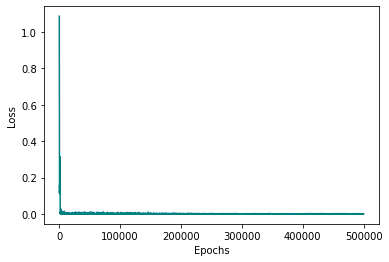

In [5]:
plt.plot(dinn.losses[0:], color = 'teal')
plt.xlabel('Epochs')
plt.ylabel('Loss')
print('total loss: ', dinn.losses[-1])
print('total error: ', dinn.errors[-1])

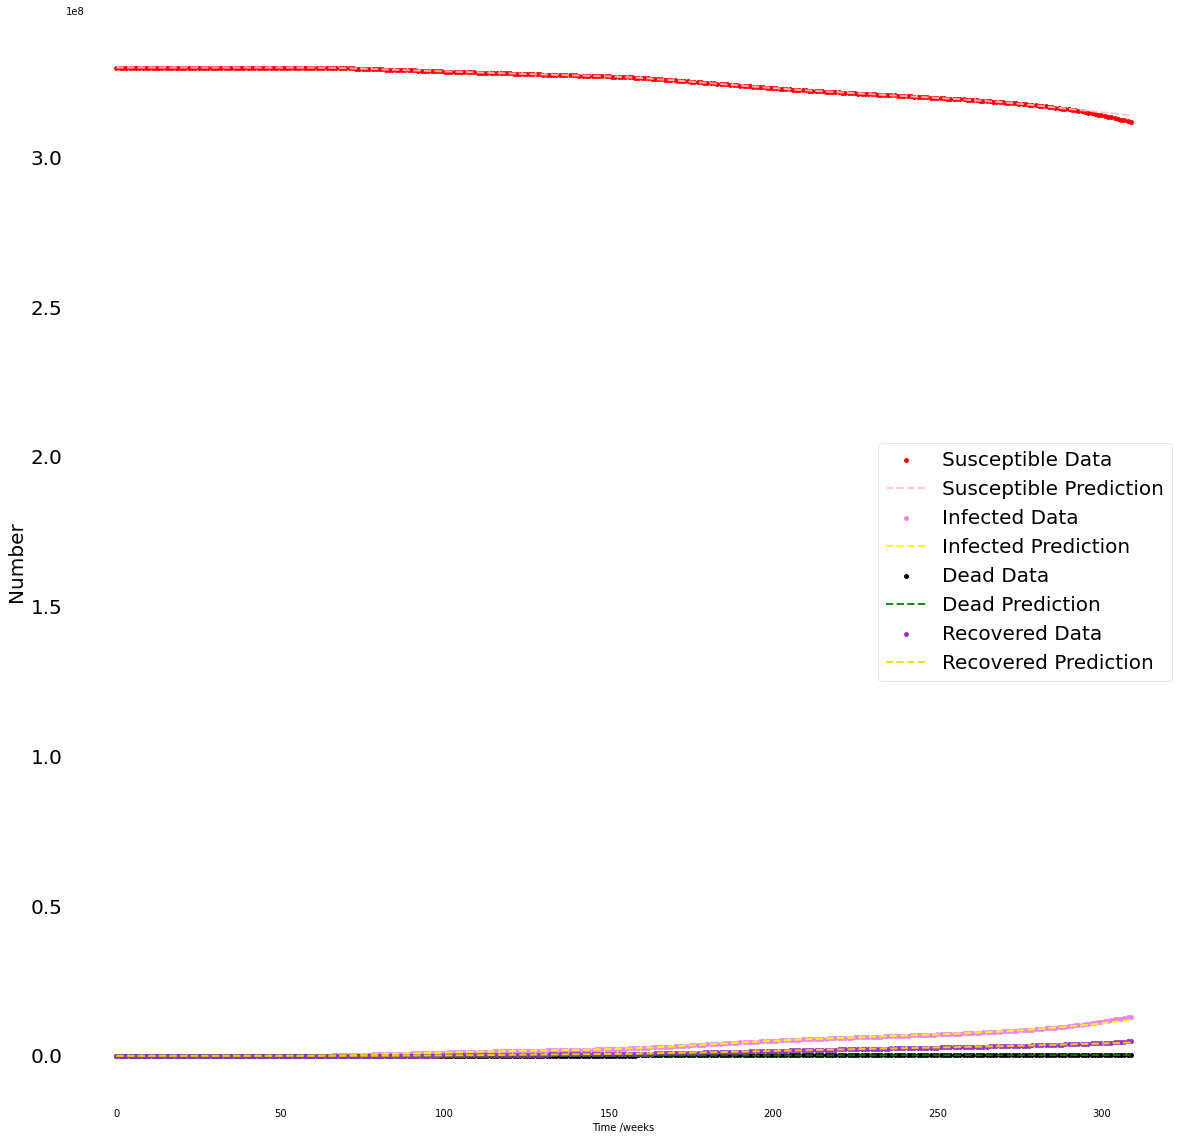

In [6]:
#sidr_data = genfromtxt('../input/covid-irdp/COVID_US_CDR_timeserise(2).csv', delimiter=',') #in the form of [t,S,I,D,R]
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')


#ax.scatter(sidr_data[0], sidr_data[1], 'pink', alpha=0.5, lw=2, label='Susceptible', s=15)
ax.scatter(sidr_data[0], sidr_data[1], color = 'red', label='Susceptible Data', s=15)
ax.plot(sidr_data[0], S_pred_list[0].detach().numpy(), 'pink', alpha=0.9, lw=2, label='Susceptible Prediction', linestyle='dashed')

# ax.scatter(sidr_data[0], sidr_data[2], 'violet', alpha=0.5, lw=2, label='Infected', s=15)
ax.scatter(sidr_data[0], sidr_data[2], color = 'violet', label='Infected Data', s=15)
ax.plot(sidr_data[0], I_pred_list[0].detach().numpy(), 'yellow', alpha=0.9, lw=2, label='Infected Prediction', linestyle='dashed')

# ax.scatter(sidr_data[0], sidr_data[3], 'darkgreen', alpha=0.5, lw=2, label='Dead', s=15)
ax.scatter(sidr_data[0], sidr_data[3], color = 'black', label='Dead Data', s=15)
ax.plot(sidr_data[0], D_pred_list[0].detach().numpy(), 'green', alpha=0.9, lw=2, label='Dead Prediction', linestyle='dashed')

# ax.scatter(sidr_data[0], sidr_data[4], 'blue', alpha=0.5, lw=2, label='Recovered', s=15)
ax.scatter(sidr_data[0], sidr_data[4], color = 'darkorchid', label='Recovered Data', s=15)
ax.plot(sidr_data[0], R_pred_list[0].detach().numpy(), 'gold', alpha=0.9, lw=2, label='Recovered Prediction', linestyle='dashed')


ax.set_xlabel('Time /weeks',size = 10)
ax.set_ylabel('Number',size = 20)
#ax.set_ylim([-1,50])
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
plt.xticks(size = 10)
plt.yticks(size = 20)
# ax.grid(b=True, which='major', c='black', lw=2.2, ls=15-')
legend = ax.legend(prop={'size':20})
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.savefig('island_40weeks.pdf')
plt.show()

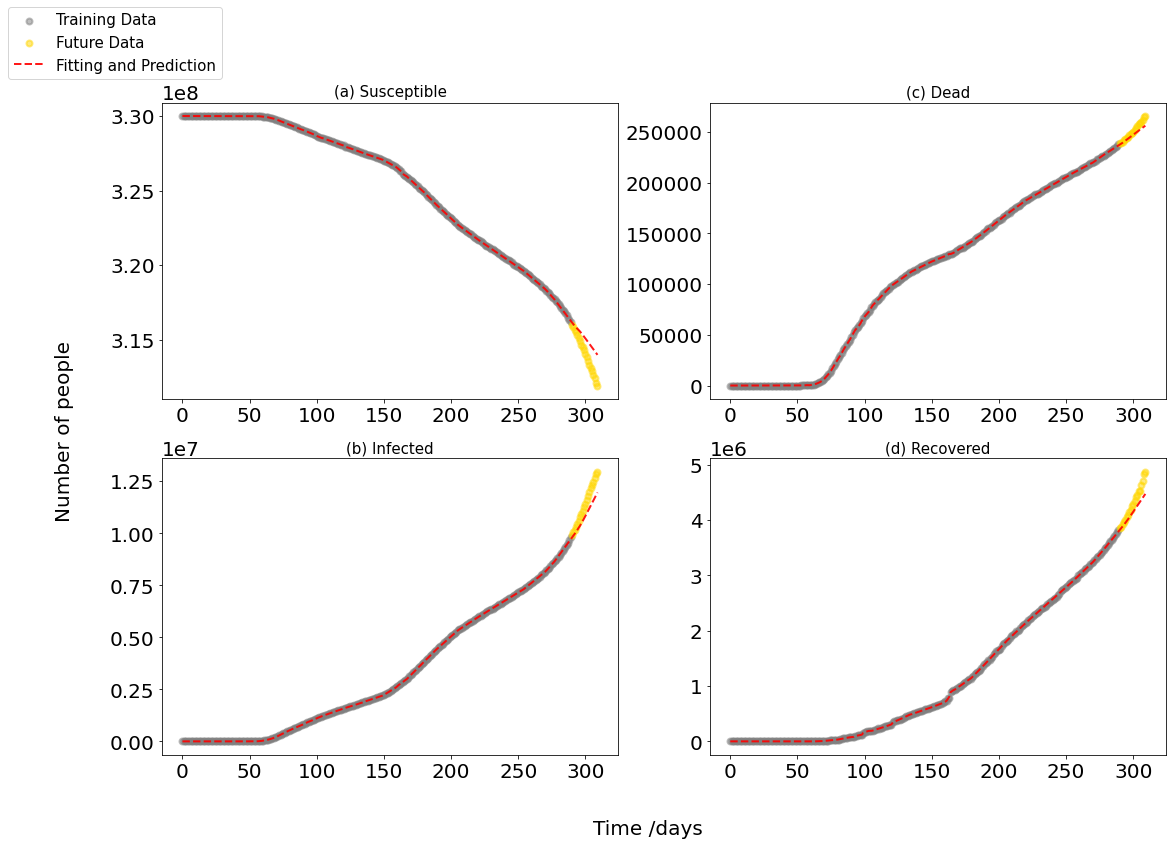

In [18]:
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

fig, ax = plt.subplots(2, 2, figsize = (18,12))


ax[0, 0].set_facecolor('xkcd:white')
ax[1, 0].set_facecolor('xkcd:white')
ax[0, 1].set_facecolor('xkcd:white')
ax[1, 1].set_facecolor('xkcd:white')
# train_day = 300
train_day = 290

ax[0, 0].scatter(sidr_data[0][:train_day], sidr_data[1][:train_day], c = 'grey', alpha=0.5, lw=2, label='Training Data')
ax[0, 0].scatter(sidr_data[0][train_day:], sidr_data[1][train_day:], c = 'gold', alpha=0.5, lw=2, label='Future Data')
ax[0, 0].plot(sidr_data[0], S_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='Fitting and Prediction', linestyle='dashed')
ax[0, 0].set_title('(a) Susceptible', fontsize=15)

ax[1, 0].scatter(sidr_data[0][:train_day], sidr_data[2][:train_day], c = 'grey', alpha=0.5, lw=2)
ax[1, 0].scatter(sidr_data[0][train_day:], sidr_data[2][train_day:], c = 'gold', alpha=0.5, lw=2 )
ax[1, 0].plot(sidr_data[0], I_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, linestyle='dashed')
ax[1, 0].set_title('(b) Infected', fontsize=15)

ax[0, 1].scatter(sidr_data[0][:train_day], sidr_data[3][:train_day], c = 'grey', alpha=0.5, lw=2 )
ax[0, 1].scatter(sidr_data[0][train_day:], sidr_data[3][train_day:], c = 'gold', alpha=0.5, lw=2 )
ax[0, 1].plot(sidr_data[0], D_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2,  linestyle='dashed')
ax[0, 1].set_title('(c) Dead', fontsize=15)

ax[1, 1].scatter(sidr_data[0][:train_day], sidr_data[4][:train_day], c = 'grey', alpha=0.5, lw=2 )
ax[1, 1].scatter(sidr_data[0][train_day:], sidr_data[4][train_day:], c = 'gold', alpha=0.5, lw=2 )
ax[1, 1].plot(sidr_data[0], R_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2,  linestyle='dashed')
ax[1, 1].set_title('(d) Recovered', fontsize=15)

# ax[0, 0].set_xlabel('Time /days',size = 20)
# ax[0, 0].set_ylabel('Number of People',size = 20)
# ax[0, 0].yaxis.set_tick_params(length=0)
# ax[0, 0].xaxis.set_tick_params(length=0)
# # ax[0, 0].grid(b=True, which='major', c='black', lw=0.2, ls='-')
# # legend = ax[0, 0].legend(prop={'size':18})
# # legend.get_frame().set_alpha(0.5)
# # for spine in ('top', 'right', 'bottom', 'left'):
# #     ax[0, 0].spines[spine].set_visible(False)
# ############################################################
# ax[1, 0].set_xlabel('Time /days',size = 20)
# ax[1, 0].set_ylabel('Number of People',size = 20)
# ax[1, 0].yaxis.set_tick_params(length=0)
# ax[1, 0].xaxis.set_tick_params(length=0)
# # ax[1, 0].grid(b=True, which='major', c='black', lw=0.2, ls='-')
# legend = ax[1, 0].legend(prop={'size':18})
# legend.get_frame().set_alpha(0.5)
# for spine in ('top', 'right', 'bottom', 'left'):
#     ax[1, 0].spines[spine].set_visible(False)
# ############################################################
# ax[0, 1].set_xlabel('Time /days',size = 20)
# ax[0, 1].set_ylabel('Number of People',size = 20)
# ax[0, 1].yaxis.set_tick_params(length=0)
# ax[0, 1].xaxis.set_tick_params(length=0)
# # ax[0, 1].grid(b=True, which='major', c='black', lw=0.2, ls='-')
# legend = ax[0, 1].legend(prop={'size':18})
# legend.get_frame().set_alpha(0.5)
# for spine in ('top', 'right', 'bottom', 'left'):
#     ax[0, 1].spines[spine].set_visible(False)
# ############################################################
# ax[1, 1].set_xlabel('Time /days',size = 20)
# ax[1, 1].set_ylabel('Number of People',size = 20)
# ax[1, 1].yaxis.set_tick_params(length=0)
# ax[1, 1].xaxis.set_tick_params(length=0)
# # ax[1, 1].grid(b=True, which='major', c='black', lw=0.2, ls='-')
# legend = ax[1,1].legend(prop={'size':18})
# legend.get_frame().set_alpha(0.5)
# for spine in ('top', 'right', 'bottom', 'left'):
#     ax[1,1].spines[spine].set_visible(False)
# ############################################################
fig.text(0.5,0.04, 'Time /days',size = 20, ha="center", va="center")
fig.text(0.05,0.5, 'Number of people',size = 20, ha="center", va="center", rotation=90)
fig.legend(loc='upper left', fontsize=15)
plt.savefig('covid_real_data_result.png')
# plt.tight_layout()
plt.show()

In [8]:
print('dinn.alpha', dinn.alpha)
print('dinn.beta', dinn.beta)
print('dinn.gamma', dinn.gamma)

dinn.alpha Parameter containing:
tensor([0.0130], requires_grad=True)
dinn.beta Parameter containing:
tensor([0.0037], requires_grad=True)
dinn.gamma Parameter containing:
tensor([0.0001], requires_grad=True)


In [9]:
#calculate relative root MSE loss
import math

S_value = 0
S_total_loss = 0
S_den = 0
S_prec = 0
I_total_loss = 0
I_den = 0
D_total_loss = 0
D_den = 0
R_total_loss = 0
R_den = 0

for timestep in range(len(sidr_data[0])):
    S_value = sidr_data[1][timestep] - S_pred_list[0][timestep]
    S_total_loss = S_value**2 + S_total_loss
    S_den = (sidr_data[1][timestep])**2 + S_den

    I_value = sidr_data[2][timestep] - I_pred_list[0][timestep]
    I_total_loss = I_value**2 + I_total_loss
    I_den = (sidr_data[2][timestep])**2 + I_den

    D_value = sidr_data[3][timestep] - D_pred_list[0][timestep]
    D_total_loss = D_value**2 + D_total_loss
    D_den = (sidr_data[3][timestep])**2 + D_den

    R_value = sidr_data[4][timestep] - R_pred_list[0][timestep]
    R_total_loss = R_value**2 + R_total_loss
    R_den = (sidr_data[4][timestep])**2 + R_den

S_total_loss = S_total_loss/S_den
I_total_loss = I_total_loss/I_den
D_total_loss = D_total_loss/D_den
R_total_loss = R_total_loss/R_den

S_total_loss = math.sqrt(S_total_loss/100)
I_total_loss = math.sqrt(I_total_loss/100)
D_total_loss = math.sqrt(D_total_loss/100)
R_total_loss = math.sqrt(R_total_loss/100)

print('S_RRMSE: ', S_total_loss*100)
print('I_RRMSE: ', I_total_loss*100)
print('D_RRMSE: ', D_total_loss*100)
print('R_RRMSE: ', R_total_loss*100)

S_RRMSE:  0.009339771585420233
I_RRMSE:  0.3181814698539446
D_RRMSE:  0.08840055834488819
R_RRMSE:  0.26094311275477966
